In [6]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='uniform', random_state=SEED)
df_dummy = cv(SEED, dc, X, y, pts, ks)

17:31:58: FOLD 1: PROF=0.0000; ATK=0.0000
17:31:58: FOLD 2: PROF=0.0000; ATK=0.0000
17:31:59: FOLD 3: PROF=0.0000; ATK=0.0000
17:31:59: FOLD 4: PROF=0.0000; ATK=0.0000
17:32:00: FOLD 5: PROF=0.0000; ATK=0.0000
17:32:00: FOLD 6: PROF=0.0000; ATK=0.0000
17:32:00: FOLD 7: PROF=0.0000; ATK=0.0000
17:32:01: FOLD 8: PROF=0.0000; ATK=0.0000
17:32:01: FOLD 9: PROF=0.0000; ATK=0.0000
17:32:02: FOLD 10: PROF=0.0000; ATK=0.0000
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed:    4.7s finished


In [3]:
qda = QDA(solver='eigen', shrinkage='auto')
df_qda = cv(SEED, qda, X, y, pts, ks, masks, preselect=5)

17:32:25: FOLD 1: PROF=0.0372; ATK=-0.0332
17:32:29: FOLD 2: PROF=0.0372; ATK=-0.0329
17:32:32: FOLD 3: PROF=0.0373; ATK=-0.0328
17:32:36: FOLD 4: PROF=0.0370; ATK=-0.0329
17:32:40: FOLD 5: PROF=0.0375; ATK=-0.0326
17:32:43: FOLD 6: PROF=0.0359; ATK=-0.0311
17:32:47: FOLD 7: PROF=0.0376; ATK=-0.0340
17:32:50: FOLD 8: PROF=0.0373; ATK=-0.0340
17:32:54: FOLD 9: PROF=0.0374; ATK=-0.0340
17:32:58: FOLD 10: PROF=0.0374; ATK=-0.0335
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed:   36.4s finished


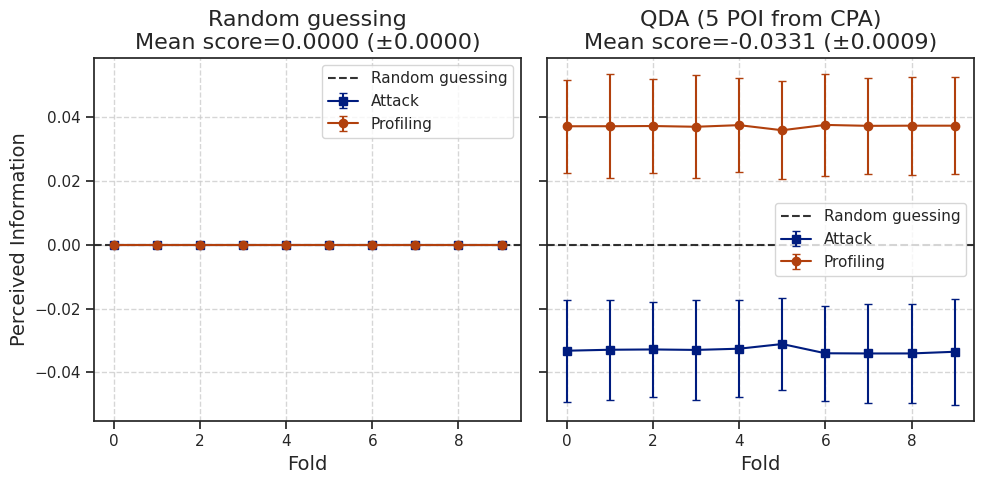

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plots.plot_cv_results(df_dummy, "Random guessing", ax=ax1)
plots.plot_cv_results(df_qda, "QDA (5 POI from CPA)", ax=ax2, ylab='')
plots.savetight(fig, "03_baseline_results")